In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [2]:
#Fetching the climate dataset from tensorflow and storing it as csv_path
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
df = pd.read_csv(csv_path)
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [4]:
#Converting first column to DATETIME format
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

<Axes: xlabel='Date Time'>

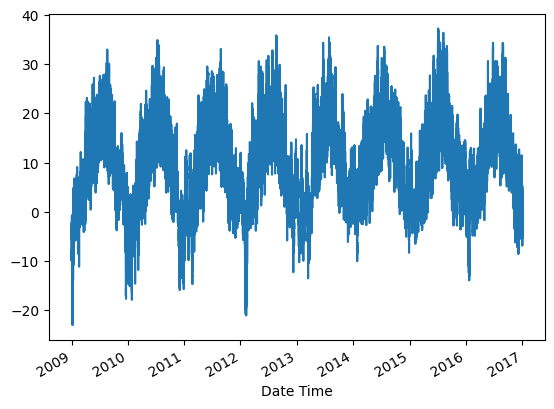

In [6]:
temp = df['T (degC)']
temp.plot()

In [10]:
#Creating a funciton that creates an X array for data in intervals of 5 and a y array that contains the labels for these series
def df2(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size): #Ensuring that window size will always be satisfied
    row = [[a] for a in df_as_np[i:i+5]] #Storing the windows into X
    X.append(row)
    label = df_as_np[i+5]  #Storing labels into Y
    y.append(label)
  return np.array(X), np.array(y)

In [13]:
WINDOW_SIZE = 5
X, y = df2(temp, WINDOW_SIZE)
X.shape, y.shape

((420546, 5, 1), (420546,))

In [16]:
#Splitting training, validation, and testing data
X_train, y_train = X[:350000], y[:350000]
X_val, y_val = X[350000:400000], y[350000:400000]
X_test, y_test = X[400000:], y[400000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((350000, 5, 1), (350000,), (50000, 5, 1), (50000,), (20546, 5, 1), (20546,))

In [19]:
#Creating the model using Sequential and LSTM for time series data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
cp = ModelCheckpoint('model1/model1.keras', save_best_only=True) # Changed filepath argument
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()]) # Corrected typo in compile method

In [23]:
#Fitting data to the model
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])


Epoch 1/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 27.5452 - root_mean_squared_error: 4.7388 - val_loss: 0.0461 - val_root_mean_squared_error: 0.2146
Epoch 2/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0496 - root_mean_squared_error: 0.2227 - val_loss: 0.0429 - val_root_mean_squared_error: 0.2071
Epoch 3/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - loss: 0.0460 - root_mean_squared_error: 0.2144 - val_loss: 0.0423 - val_root_mean_squared_error: 0.2056
Epoch 4/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 0.0455 - root_mean_squared_error: 0.2134 - val_loss: 0.0427 - val_root_mean_squared_error: 0.2066
Epoch 5/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.0439 - root_mean_squared_error: 0.2096 - val_loss: 0.0427 - val_root_mean_squared_error: 0.2066
Epoch 6/10
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.0443 - root_mean_squared_error: 0.2104 - val_loss: 0.0420 - val_root_mean_squared_error: 0.2050
Epoch 7/10
10938/1093

In [25]:
#Saving the best model
from tensorflow.keras.models import load_model
model1 = load_model('model1/model1.keras')

In [28]:
train_prediction = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_prediction, 'Actuals':y_train.flatten()})

10938/10938 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


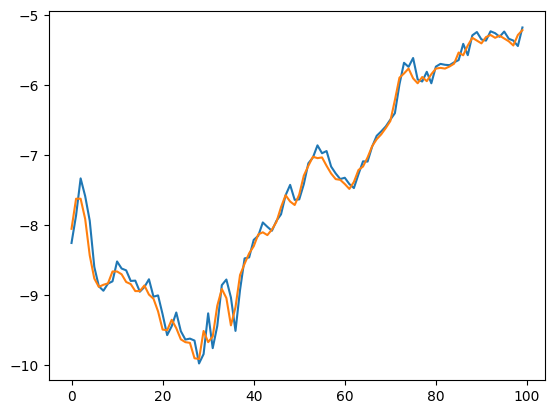

In [30]:
#Plotting predictions from testing data against the actual data
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][:100])
plt.plot(train_results['Actuals'][:100])


In [33]:
val_prediction = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_prediction, 'Actuals':y_val.flatten()})

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


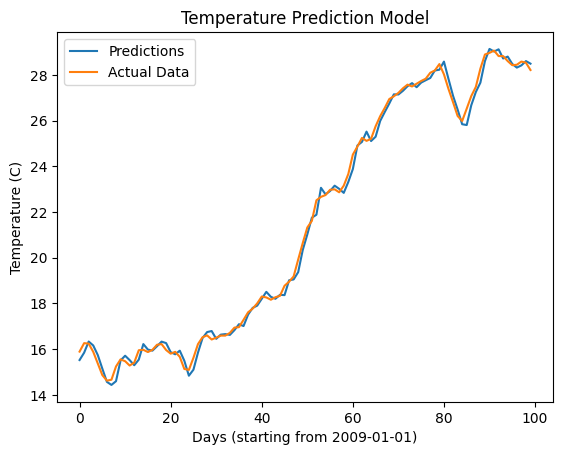

In [37]:
#Final plot of data
import matplotlib.pyplot as plt
plt.plot(val_results['Train Predictions'][:100], label = 'Predictions')
plt.plot(val_results['Actuals'][:100], label = 'Actual Data')
plt.xlabel("Days (starting from 2009-01-01)")
plt.ylabel("Temperature (C)")
plt.title("Temperature Prediction Model")
plt.legend()
plt.show()
